##### This notebook is a quick implementation of the third model applied to oil proposed by E. S. Schwartz; The Stochastic Behavior of Commodity Prices: Implications for Valuation and Hedging; July 3, 1997.
We represent the evolution of the spot price and the convenience yield of oil for two years under the risk neutral measure. We added the possibility of an exogenous shock to the variables at a time generated by an exponential law and compare the trajectories with/without shock.

Spot price follows a standard Brownian process, convenience yield follows a mean-reversion process and the interest rate follows an Ornstein-Uhlenbeck process as in Vasicek (1977).

In [2]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [3]:
T = 2.0 # two years
dt = 1.0/250.0 #time step = one business day
timestep = int(T/dt)

In [4]:
# Parameters from the paper: third model, oil data
sigma1 = 0.344
kappa = 1.314
alpha = 0.249
sigma2 = 0.372
a = 0.2
Rinf = 0.07
sigma3 = 0.0081
rho1 = 0.915
rho2 = -0.0039
rho3 = -0.0293

m = Rinf + sigma3*sigma3/(2*a*a)
mean = [0.0,0.0,0.0]
cov = [[1.0,rho1,rho3],[rho1,1.0,rho2],[rho3,rho2,1.0]]

In [9]:
# Shock time generated with an exponential law, shock happens on average every 500 days = 2 years
T_shock = int(-np.log(np.random.uniform(0,1))*500)
T_shock

163

In [13]:
# Initial state
S = [60.0]
Sc= [60.0]
delta = [0.1]
deltac = [0.1]
r = [0.05]
shockd = 0.0 #shock on convenience yield
shocks = 0.0 #shock on spot price

# Generating paths
for i in range(0,timestep):
    
    # Define shock instant
    if i==T_shock:
        shockd = 1.5 #convenience yield raises by 150 percents
        shocks = 0.1 #spot price raises by 10 percents
        #print('shock')
    else:
        shockd = 0.0
        shocks = 0.0
    
    #Generate three correlated Brownian motion increments
    dz = np.random.multivariate_normal(mean, cov, 1).T
    dz1, dz2, dz3 = dz[0,0], dz[1,0], dz[2,0]
    
    #Compute increments
    ds = (r[-1]-delta[-1])*S[-1]*dt + sigma1*S[-1]*dz1*np.sqrt(dt) - shocks*S[-1]
    ddelta = kappa*(alpha-delta[-1])*dt + sigma2*dz2*np.sqrt(dt) + shockd*abs(delta[-1])
    dr = a*(m-r[-1])*dt + sigma3*dz3*np.sqrt(dt)
    
    # Generate the path not shocked
    if i>=T_shock:
        dsc = (r[-1]-deltac[-1])*Sc[-1]*dt + sigma1*Sc[-1]*dz1*np.sqrt(dt)
        ddeltac = kappa*(alpha-deltac[-1])*dt + sigma2*dz2*np.sqrt(dt)
    else:
        dsc = ds
        ddeltac = ddelta
    
    #Updating variables
    S.append(S[-1] + ds)
    Sc.append(Sc[-1] + dsc)
    delta.append(delta[-1] + ddelta)
    deltac.append(deltac[-1] + ddeltac)
    r.append(r[-1] + dr)

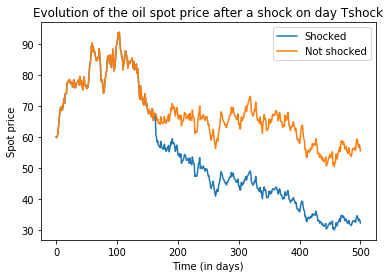

In [14]:
plt.plot(S)
plt.plot(Sc)
plt.xlabel('Time (in days)')
plt.ylabel('Spot price')
plt.title('Evolution of the oil spot price after a shock on day Tshock')
plt.legend(['Shocked','Not shocked'])
plt.show()

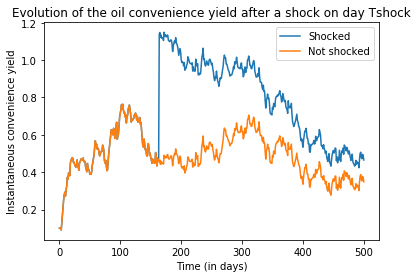

In [15]:
plt.plot(delta)
plt.plot(deltac)
plt.xlabel('Time (in days)')
plt.ylabel('Instantaneous convenience yield')
plt.title('Evolution of the oil convenience yield after a shock on day Tshock')
plt.legend(['Shocked','Not shocked'])
plt.show()

#### Computing the effect of the shock on the 1-month future price

In [16]:
maturity = 20.0/250 #arround 1 month in business day

In [22]:
#Computing terms for calculating future value
first = (kappa*alpha+sigma1*sigma2*rho1)*((1-np.exp(-kappa*maturity))-kappa*maturity)/(kappa**2)
second = -sigma2**2*(4*(1-np.exp(-kappa*maturity)) - (1-np.exp(-2*kappa*maturity)) -2*kappa*maturity)/(4*kappa**3)
third = -1*(a*m + sigma1*sigma3*rho3)*((1-np.exp(-a*maturity)) - a*maturity)/(a**2)
fourth = -sigma3**2*(4*(1-np.exp(-a*maturity)) - (1-np.exp(-2*a*maturity)) - 2*a*maturity)/(4*a**3)
fifth = sigma2*sigma3*rho2*((1-np.exp(-kappa*maturity)) + (1-np.exp(-a*maturity)) - (1-np.exp(-(kappa+a)*maturity)))/(kappa*a*(kappa+a))
sixth = sigma2*sigma3*rho2*(kappa**2*(1-np.exp(-a*maturity)) + a**2*(1-np.exp(-kappa*maturity)) - kappa*a**2*maturity - a*kappa**2*maturity)/(kappa**2*a**2*(kappa+a))

In [27]:
C_T = first +second + third + fourth + fifth + sixth

In [39]:
# Using the analytical form provided in the article
F = np.array(S) * np.exp(-np.array(delta)*(1-np.exp(-kappa*maturity))/kappa + np.array(r)*(1-np.exp(-a*maturity))/a + C_T)

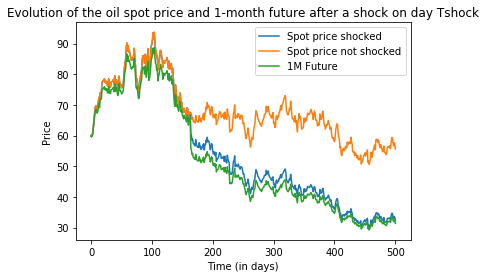

In [44]:
plt.plot(S)
plt.plot(Sc)
plt.plot(F)
plt.xlabel('Time (in days)')
plt.ylabel('Price')
plt.title('Evolution of the oil spot price and 1-month future after a shock on day Tshock')
plt.legend(['Spot price shocked','Spot price not shocked','1M Future'])
plt.show()